In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext watermark

In [4]:
import sys
sys.path.append('/home/caleml/grotile')

In [ ]:
from tabular.agent import RandomAgent, QLAgent, SQLAgent, MIRLAgent, SQL_mAgent
from tabular.environment import GridWorld

In [ ]:
from tabular.main import eval_snapshot, plot_results, plot_correct_action

In [ ]:
from tabular.main import eval_snapshot, plot_results, plot_correct_action

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from types import SimpleNamespace

import datetime
import json
import frozendict
import random
import os
from pprint import pprint
from collections import defaultdict

# config

In [ ]:
world1 = {
    'size': (3, 20),
    'reward': (1, 18),
    'walls': []
}

world2 = {
    'size': (8, 8),
    'reward': (3, 5),
    'walls': [(2, 4), (2, 5), (3, 4), (4, 4), (4, 5)]
}

config = frozendict.frozendict({
    'eps_train': 0.1,
    'eps_eval': 0.05,
    'gamma': 0.99,
    'rho_lr': 2e-3,
    'beta_lr': 2e-3,   # use?
    'c': 1e-3,
    'omega': 0.8,
    'max_steps': 10000
})

# main loop

In [ ]:
config = SimpleNamespace(**config)

In [ ]:
def eval_snapshot(agent_class, agent_checkpoint, world_conf):
    '''
    described in the paper: "The evaluation for a single snapshot is conducted by running the policy for 
    30 episodes lasting at most 100 environment steps. The epsilon value when in evaluation mode is set to 0.05.   
    Every individual experiment is repeated with 10 different initial random seeds and results are averaged"
    '''
    n_seeds = 10
    n_episodes = 30
    max_t = 100
    rewards = list()
    
    env = GridWorld(world_conf)
    agent = agent_class(env.get_actions(), config, **agent_checkpoint, mode='eval')
    
    for i_seed in range(n_seeds):
        np.random.seed()
        seed_results = list()
        
        for i_episode in range(n_episodes):
            episode_reward = 0
            obs = env.reset()
            
            for t in range(max_t):
                action = agent.choose_action(obs)
                reward, next_obs, done = env.action(action)
                
                obs = next_obs
                episode_reward += reward
    
                if done:
                    break
            
            seed_results.append(episode_reward)
            
        rewards.append(np.mean(seed_results))
      
    return np.mean(rewards)
    

In [ ]:
# evaluation_data will store info for plot 1
evaluation_data = defaultdict(dict)
training_data = defaultdict(dict)

envs = {
    'Grid_World_3x20': world1,
    'Grid_World_8x8': world2
}

# storing info for plot 2
correct_info = defaultdict(dict)

exp_name = '10k_sqlm'
ROOT_DIR = '/home/caleml/grotile'

log_folder = ROOT_DIR + '/tabular/logs/%s_%s' % (datetime.datetime.now().strftime('%Y%m%d_%H%M%S'), exp_name)
log_step = 1000

for envname, envconf in envs.items():
    env = GridWorld(envconf)
        
    for agent_class in (SQL_mAgent, QLAgent, SQLAgent, MIRLAgent):
        log_subfolder = os.path.join(log_folder, envname.replace(' ', '_'), agent_class.__name__)
        os.makedirs(log_subfolder)
        
        with open(os.path.join(log_subfolder, 'logs.csv'), 'w+') as f_log:
            print('\nTraining agent %s' % agent_class.__name__)
            agent = agent_class(env.get_actions(), config)

            total_reward = 0
            obs = env.reset()
            evals = dict()
            train = dict()
            correct_action = list()

            for global_step in range(config.max_steps):
                action = agent.choose_action(obs)
                reward, next_obs, done = env.action(action)

                agent.update(obs, action, reward, next_obs, done)

                if (global_step + 1) % 100 == 0:
                    eval_reward = eval_snapshot(agent_class, agent.get_checkpoint(), envconf)
                    evals[global_step] = eval_reward
                    print('Step %s, reward eval %s' % (global_step + 1, eval_reward))

                if (global_step + 1) % log_step == 0:
                    agent.log(log_subfolder, global_step)
                    log_vars = ','.join([str(global_step), str(eval_reward)] + agent.get_current_vars()) + '\n'
                    f_log.write(log_vars)
                    
                # correct action information (different evaluation for both gridworlds)
                if envname == 'Grid World 3x20':        # log correct action at each step
                    correct_action.append(1 if action == 1 else 0)
                elif envname == 'Grid World 8x8':       # log correct action at state (3,6)
                    x_agent, y_agent = np.where(obs == 3)
                    if (x_agent[0], y_agent[0]) == (3, 6):
                        correct_action.append(1 if action == 3 else 0)
                    
                total_reward += reward
                obs = next_obs
                # env.display()
                
                if done:
                    # print("Env done with reward %s" % total_reward)
                    train[global_step] = total_reward
                    total_reward = 0
                    obs = env.reset()

        evaluation_data[envname][agent_class.__name__] = evals
        training_data[envname][agent_class.__name__] = train
        correct_info[envname][agent_class.__name__] = correct_action
            
        with open(os.path.join(log_subfolder, 'eval_data.json'), 'w+') as f_dump:
            f_dump.write(json.dumps(evals))
        
        with open(os.path.join(log_subfolder, 'correct_action.json'), 'w+') as f_correct:
            f_correct.write(json.dumps({'data': correct_action}))


# plots

In [7]:
paper_colors = {
    'QLAgent': 'g',
    'SQLAgent': 'orangered',
    'SQL_mAgent': 'orange',
    'MIRLAgent': 'royalblue'
}

In [22]:
def plot_results(evaluation_data, log_folder):
    for envname, env_eval_data in evaluation_data.items():
        for agent_type, eval_data in env_eval_data.items():
            data_x = np.array(list(eval_data.keys()))
            data_y = np.array(list(eval_data.values()))
            x_smooth = np.linspace(data_x.min(), data_x.max(), 200)
            f_smooth = interp1d(data_x, data_y, kind='cubic')
            df = pd.Series(data_y)
            plt.plot(data_x, df.ewm(span=10).mean(), paper_colors[agent_type], label='%s' % agent_type.replace('Agent', ''))

            # plt.plot(x_smooth, f_smooth(x_smooth), paper_colors[agent_type], label='%s eval RAW' % agent_type, alpha=0.4)
            # plt.plot(ewma(data_x, span=1000), label='%s train EWMA' % agent_type)

        plt.xlabel('environment interactions')
        plt.ylabel('reward')
        plt.legend()
        plt.title(envname)
        
        if log_folder:
            plt.savefig(log_folder + '/results_%s.png' % envname)
            
        plt.show()
        

In [ ]:
plot_results(evaluation_data)

In [23]:
# plot correct action

def plot_correct_action(correct_info, log_folder=None):
    labels = {
        'Grid_World_3x20': {
            'title': 'Correct action while training',
            'x_label': 'Training step',
            'y_label': '1: Correct action (right), 0: Incorrect action'
        },
        'Grid_World_8x8': {
            'title': 'Correct Infrequent action',
            'x_label': 'Interactions in state (3, 6)',
            'y_label': '1: Correct action (left), 0: Incorrect action'
        } 
    }

    for envname, correct_data in correct_info.items():
        envname = envname.replace(' ', '_')
        for agent_type, correct_action in correct_data.items():
            data_x = np.arange(0, len(correct_action), 1)
            data_y = np.array(correct_action)
            df = pd.Series(correct_action)
            plt.plot(data_x, df.ewm(span=1000).mean(), paper_colors[agent_type], label=agent_type.replace('Agent', ''))

        plt.xlabel(labels[envname]['x_label'])
        plt.ylabel(labels[envname]['y_label'])
        plt.legend()
        plt.title(labels[envname]['title'])
        
        if log_folder:
            plt.savefig(log_folder + '/actions_%s.png' % envname)
            
        plt.show()

In [ ]:
plot_correct_action(correct_info)

# plot existing experiments

In [ ]:
experiment_dir = "/Users/voltali/tmp_projects/grotile/tabular/logs/20190104_230535_all_10k"

env_names = ['Grid_World_3x20', 'Grid_World_8x8']
agent_names = ['QLAgent', 'SQLAgent', 'SQL_mAgent', 'MIRLAgent']

eval_data = defaultdict(dict)
correct_data = defaultdict(dict)

for envname in env_names:
    for agentname in agent_names:
        data_path = os.path.join(experiment_dir, envname, agentname, 'eval_data.json')
        with open(data_path, 'r') as f_eval:
            data = json.loads(f_eval.read())
            eval_data[envname][agentname] = {int(k): v for k, v in data.items()}
            
        correct_action_path = os.path.join(experiment_dir, envname, agentname, 'correct_action.json')
        with open(correct_action_path, 'r') as f_correct:
            data = json.loads(f_correct.read())
            correct_data[envname][agentname] = data['data']
            
plot_results(eval_data)
plot_correct_action(correct_data)

# plot experiments from different folders

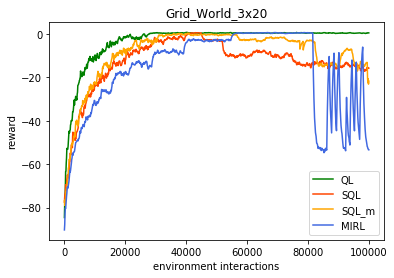

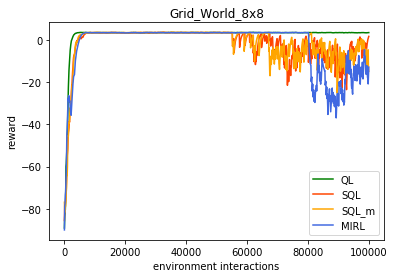

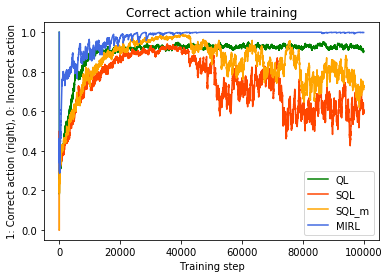

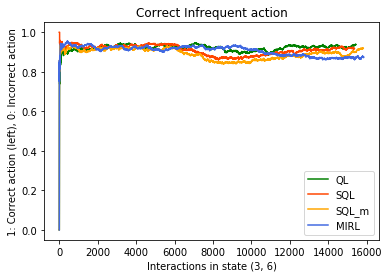

In [24]:
# 100k MIRL on 3x20 and 8x8 (old)
mirl = "/Users/voltali/tmp_projects/grotile/tabular/logs/results/20190104_203749_100k_mirl"

# 100k all on 8x8
all_8x8 = "/Users/voltali/tmp_projects/grotile/tabular/logs/results/20190106_161824_100k_all_8x8"

# 100k all on 3x20
all_3x20 = "/Users/voltali/tmp_projects/grotile/tabular/logs/results/20190105_020922_all_100k"

paths = {
    'Grid_World_3x20': {
        'QLAgent': all_3x20,
        'SQLAgent': all_3x20,
        'SQL_mAgent': all_3x20,
        'MIRLAgent': mirl
    },
    'Grid_World_8x8': {
        'QLAgent': all_8x8,
        'SQLAgent': all_8x8,
        'SQL_mAgent': all_8x8,
        'MIRLAgent': mirl
    }
}

eval_data = defaultdict(dict)
correct_data = defaultdict(dict)

savedir = "/Users/voltali/tmp_projects/grotile/tabular/logs/results"

for envname, data in paths.items():
    for agentname, basedir in data.items():
        data_path = os.path.join(basedir, envname, agentname, 'eval_data.json')
        with open(data_path, 'r') as f_eval:
            data = json.loads(f_eval.read())
            eval_data[envname][agentname] = {int(k): v for k, v in data.items()}
            
        correct_action_path = os.path.join(basedir, envname, agentname, 'correct_action.json')
        with open(correct_action_path, 'r') as f_correct:
            data = json.loads(f_correct.read())
            correct_data[envname][agentname] = data['data']
            
plot_results(eval_data, log_folder=savedir)
plot_correct_action(correct_data, log_folder=savedir)
        


# Performance drop investigation

In [ ]:
exp_dir = ""